In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
data = open('input.txt', 'r').read()
data=list(data)
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print("data has %d characters, %d unique" % (data_size, vocab_size))

data has 2454043 characters, 97 unique


In [3]:
char_to_idx = {ch:i for i,ch in enumerate(chars)}
idx_to_char = {i:ch for i,ch in enumerate(chars)}

In [4]:
class LSTM():
    def __init__(self,train_datas,char_to_idx,vocab_size,hidden_nums=100,T_steps=25,batch_size=64):
        self.train_datas=train_datas  #训练数据,list
        self.char_to_idx=char_to_idx
        self.vocab_size=vocab_size
        self.hidden_nums=hidden_nums  #中间层数量
        self.T_steps=T_steps  #时间步
        self.batch_size=batch_size
        self.batch_index=0
        self.init_params()



    def init_params(self):
        #遗忘门
        self.Wf=np.random.randn(self.hidden_nums,self.hidden_nums+self.vocab_size)*0.1+0.5
        self.bf=np.zeros((self.hidden_nums,1))
        #更新门
        self.Wu = np.random.randn(self.hidden_nums, self.hidden_nums + self.vocab_size) * 0.1 + 0.5
        self.bu = np.zeros((self.hidden_nums, 1))
        # 更新单元
        self.Wc = np.random.randn(self.hidden_nums, self.hidden_nums + self.vocab_size) * 0.1
        self.bc = np.zeros((self.hidden_nums, 1))
        # 输出门
        self.Wo = np.random.randn(self.hidden_nums, self.hidden_nums + self.vocab_size) * 0.1 + 0.5
        self.bo = np.zeros((self.hidden_nums, 1))

        #输出
        # 更新门
        self.Wy = np.random.randn( self.vocab_size,self.hidden_nums) * 0.1
        self.by = np.zeros((self.vocab_size, 1))

        print('initial params complete!')





    def forward(self,X,Y,a_prev,c_prev):
        z,a,c,cc,y_hat,tao_o,tao_u,tao_f={},{},{},{},{},{},{},{}
        a[-1]=np.copy(a_prev)
        c[-1]=np.copy(c_prev)
        loss=0
        for t in range(X.shape[0]):
            x=np.zeros((self.vocab_size,1))

            x[X[t]]=1  #one-hot

            z[t]=np.row_stack((a[t-1],x))
            tao_f[t]=self.sigmoid(self.Wf.dot(z[t])+self.bf)
            tao_u[t]=self.sigmoid(self.Wu.dot(z[t])+self.bu)
            cc[t]=np.tanh(self.Wc.dot(z[t])+self.bc)
            c[t]=tao_f[t]*c[t-1]+tao_u[t]*cc[t]
            tao_o[t]=self.sigmoid(self.Wo.dot(z[t])+self.bo)
            a[t]=tao_o[t]*np.tanh(c[t])

            y_hat[t]=self.softmax(self.Wy.dot(a[t])+self.by)
            loss-=np.log(y_hat[t][Y[t]])
        return (z,a,c,cc,tao_o,tao_u,tao_f,y_hat),loss,a[self.T_steps-1],c[self.T_steps-1]



    def backward(self,X,Y,cache):
        (z, a, c,cc,tao_o,tao_u,tao_f,y_hat)=cache
        da_next=np.zeros_like(a[0])
        dc_next=np.zeros_like(c[0])
        dWy=np.zeros_like(self.Wy)
        dby=np.zeros_like(self.by)
        dWo=np.zeros_like(self.Wo)
        dbo=np.zeros_like(self.bo)
        dWc=np.zeros_like(self.Wc)
        dbc=np.zeros_like(self.bc)
        dWu=np.zeros_like(self.Wu)
        dbu=np.zeros_like(self.bu)
        dWf=np.zeros_like(self.Wf)
        dbf=np.zeros_like(self.bf)
        for t in reversed(range(X.shape[0])):

            dy=np.copy(y_hat[t])
            dy[Y[t]]-=1

            dWy+=dy.dot(a[t].T)
            # dby+=np.sum(dy,axis=1,keepdims=True)
            dby+=dy

            da=self.Wy.T.dot(dy)
            da+=da_next

            dtao_ot=np.multiply(da,np.tanh(c[t]))
            do=np.multiply(self.sigmoid_derivate(tao_o[t]),dtao_ot)
            dWo+=do.dot(z[t].T)
            # dbo+=np.sum(do,axis=1,keepdims=True)
            dbo+=do

            dc=np.copy(dc_next)
            dc+=np.multiply(np.multiply(da,tao_o[t]),self.tanh_derivate(np.tanh(c[t])))

            dcct=np.multiply(dc,tao_u[t])
            dcct_before_activation=np.multiply(dcct,self.tanh_derivate(cc[t]))
            dWc+=dcct_before_activation.dot(z[t].T)
            # dbc+=np.sum(dcct_before_activation,axis=1,keepdims=True)
            dbc+=dcct_before_activation

            dtao_ut=np.multiply(dc,cc[t])
            du=np.multiply(self.sigmoid_derivate(tao_u[t]),dtao_ut)
            dWu+=du.dot(z[t].T)
            # dbu+=np.sum(du,axis=1,keepdims=True)
            dbu+=du

            dtao_ft=np.multiply(dc,c[t-1])
            df=np.multiply(self.sigmoid_derivate(tao_f[t]),dtao_ft)
            dWf+=df.dot(z[t].T)
            # dbf+=np.sum(df,axis=1,keepdims=True)
            dbf+=df

            dz=self.Wf.T.dot(df)+self.Wu.T.dot(du)+self.Wo.T.dot(do)+self.Wc.T.dot(dcct_before_activation)

            da_next=dz[:self.hidden_nums,:]
            dc_next=np.multiply(dc,tao_f[t])

        return {'dWf':dWf,'dWu':dWu,'dWc':dWc,'dWo':dWo,'dWy':dWy,'dbf':dbf,'dbu':dbu,'dbc':dbc,'dbo':dbo,'dby':dby}






    def GradientDescentOptimizer(self,learning_rate,iterations=10000):
        loss_history=np.zeros((iterations,1))
        for i in range(iterations):
            X, Y = self.next_data()
            if self.batch_index==self.T_steps or i==0:
                a_prev = np.zeros((self.hidden_nums, 1))
                c_prev = np.zeros((self.hidden_nums, 1))
            
            cache,loss,a_prev,c_prev=self.forward(X,Y,a_prev,c_prev)

            loss_history[i]=loss
            gradients=self.backward(X,Y,cache)
            cliped_gradients=self.clip_gradients(gradients,2)
            self.update_params(cliped_gradients,learning_rate)


        plt.plot(loss_history)
        plt.show()



    def clip_gradients(self,gradients,value):
        for graident in gradients.values():
            np.clip(graident,-value,value,out=graident)
        return gradients



    def update_params(self,gradients,lr):
        self.Wf-=lr*gradients['dWf']
        self.Wu-=lr*gradients['dWu']
        self.Wc-=lr*gradients['dWc']
        self.Wo-=lr*gradients['dWo']
        self.Wy-=lr*gradients['dWy']
        self.by-=lr*gradients['dby']
        self.bf-=lr*gradients['dbf']
        self.bu-=lr*gradients['dbu']
        self.bc-=lr*gradients['dbc']
        self.bo-=lr*gradients['dbo']




    def next_data(self):
        if self.batch_index+self.T_steps+1>=len(self.train_datas):
            self.batch_index=0
        start=self.batch_index
        end=self.batch_index+self.T_steps
        X = np.array([self.char_to_idx[ch] for ch in self.train_datas[start:end]]).reshape(-1,1)
        Y = np.array([self.char_to_idx[ch] for ch in self.train_datas[start + 1:end + 1]]).reshape(-1,1)
        self.batch_index=end
        return X,Y



    def sigmoid(self,z):
        return 1/(1+np.exp(-z))


    def sigmoid_derivate(self,a):
        return np.multiply(a,1-a)


    def tanh_derivate(self,c):
        return 1-np.square(c)


    def softmax(self,z):
        return np.exp(z)/np.sum(np.exp(z))

initial params complete!


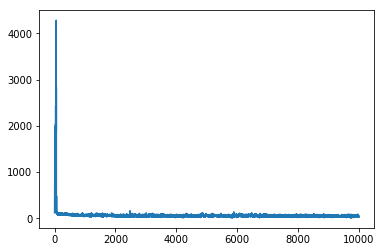

In [5]:
lstm=LSTM(data,char_to_idx,vocab_size)
lstm.GradientDescentOptimizer(0.1)